# Evaluation of SRIM stopping power extrapolations to transuranium elements

In [1]:
%run GenerateStoppingPower.ipynb

/home/yulia/anaconda3/lib/python3.7/site-packages/srim/core/elementdb.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(open(dbpath, "r"))


SRIM stopping power successfully calculated
	Calculate energy loss as a function of traversed target material with function 'GetElossAfterX(E_init, x)'
	Calculate traversed target material as a function of energy loss 'GetXAfterEloss(E_init, E_after)'
	Calculate range in material as a function of energy 'GetRange(E_init)'
	Units: MeV, µm
Successfully imported 'GenerateStoppingPower'
	Class to Generate SRIM Stopping Power and calculate energy loss and traversed material.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.linalg
from matplotlib import colors
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

color_list = plt.rcParams['axes.prop_cycle'].by_key()['color'];
#Customising style
#mpl.rc('lines', linewidth=2, color='r')
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['font.size'] = 24
#mpl.rcParams['savefig.format'] = "eps"
#mpl.rcParams['savefig.dpi'] = 100
#mpl.rcParams['text.usetex'] = True
#mpl.rcParams['figure.figsize'] = (16,9)

## Ion

Example SiO2 layer as material

In [3]:
# Construct a layer of UO2, arbitrary width (as it is not relevant for these calcs)
layer = Layer({
    'Si': {
        'stoich': 1,
        #'E_d': 35.0, # Displacement Energy
        #'lattice': 0.0,
        #'surface': 3.0
    },
    'O': {
        'stoich': 2,
        #'E_d': 20.0, # Displacement Energy
        #'lattice': 0.0,
        #'surface': 3.0
    }
}, density=2.32, width=10000.0)

Example ion is No-254.

In [4]:
# Construct ion
A, E_per_A_max = 254, 7e6 # nucleon number, eV 
energy_max = A*E_per_A_max
#print("Max energy=", energy_max)
ion = Ion('U', energy=energy_max, mass=A)

In [5]:
U254 = GenerateStoppingPower(layer, ion)

SRIM stopping power successfully calculated
	Calculate energy loss as a function of traversed target material with function 'GetElossAfterX(E_init, x)'
	Calculate traversed target material as a function of energy loss 'GetXAfterEloss(E_init, E_after)'
	Calculate range in material as a function of energy 'GetRange(E_init)'
	Units: MeV, µm


In [6]:
No254 = GenerateStoppingPower(layer, ion, z_ion=102)

Extrapolating stopping power for ion with z= 102
Mean scaling factor: 1.1474923319670072
SRIM stopping power successfully calculated
	Calculate energy loss as a function of traversed target material with function 'GetElossAfterX(E_init, x)'
	Calculate traversed target material as a function of energy loss 'GetXAfterEloss(E_init, E_after)'
	Calculate range in material as a function of energy 'GetRange(E_init)'
	Units: MeV, µm


In [7]:
# Construct ion
A, E_per_A_max = 289, 7e6 # nucleon number, eV 
energy_max = A*E_per_A_max
#print("Max energy=", energy_max)
ion = Ion('U', energy=energy_max, mass=A)
Fl289 = GenerateStoppingPower(layer, ion, z_ion=114)

Extrapolating stopping power for ion with z= 114
Mean scaling factor: 1.3309325475011262
SRIM stopping power successfully calculated
	Calculate energy loss as a function of traversed target material with function 'GetElossAfterX(E_init, x)'
	Calculate traversed target material as a function of energy loss 'GetXAfterEloss(E_init, E_after)'
	Calculate range in material as a function of energy 'GetRange(E_init)'
	Units: MeV, µm


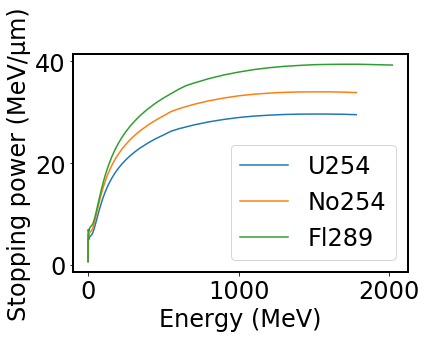

In [8]:
plt.figure()
plt.plot(U254.energy_raw, U254.dEdX_raw, label='U254')
plt.plot(No254.energy_raw, No254.dEdX_raw, label='No254')
plt.plot(Fl289.energy_raw, Fl289.dEdX_raw, label='Fl289')
plt.xlabel('Energy (MeV)')
plt.ylabel('Stopping power (MeV/µm)')
plt.legend()
plt.show()

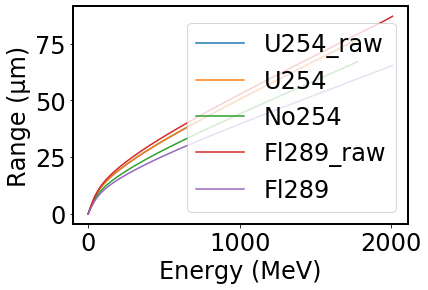

In [9]:
plt.figure()
plt.plot(U254.energy_raw, U254.GetRange(U254.energy_raw), label='U254_raw')
plt.plot(U254.energy_raw, U254.GetRange(U254.energy_raw, from_sr=True), label='U254')
plt.plot(No254.energy_raw, No254.GetRange(No254.energy_raw, from_sr=True), label='No254')
plt.plot(Fl289.energy_interp, Fl289.GetRange(Fl289.energy_interp), label='Fl289_raw')
plt.plot(Fl289.energy_interp, Fl289.GetRange(Fl289.energy_interp, from_sr=True), label='Fl289')

plt.xlabel('Energy (MeV)')
plt.ylabel('Range (µm)')
plt.legend()
plt.show()

## Material

Example PuO2 layer as material.

Method goes as follows: 

1. First construct the layer, but replacing the transuranic element with uranium (this is denoted the reference layer). 
2. As usual, construct the ion.
3. Calculate mean/effective nuclear charge for the reference layer and the desired layer.
4. Generate the stopping power providing objects given in points 1-3.

1. Construct layer

In [10]:
# Construct a layer of SiO2, arbitrary width (as it is not relevant for these calcs)
layer = Layer({
    'U': {
        'stoich': 1,
        #'E_d': 35.0, # Displacement Energy
        #'lattice': 0.0,
        #'surface': 3.0
    },
    'O': {
        'stoich': 2,
        #'E_d': 20.0, # Displacement Energy
        #'lattice': 0.0,
        #'surface': 3.0
    }
}, density=11.5, width=10000.0) #density from PuO2 wikipedia

2. Example ion is Ca-48.

In [11]:
# Construct ion
A, E_per_A_max = 48, 7e6 # nucleon number, eV 
energy_max = A*E_per_A_max
#print("Max energy=", energy_max)
ion = Ion('Ca', energy=energy_max, mass=A)

3. Calculating mean/effective nuclear charge for reference layer and desired layer.

In [12]:
Z_UO2 = (92+2*8)/3.
Z_PuO2 = (94+2*8)/3.

4. Generate stopping power.

In [13]:
PuO2 = GenerateStoppingPower(layer, ion, Z=Z_PuO2, Z_ref=Z_UO2)

Extrapolating stopping power for material with Z= 36.666666666666664
Scaling factor: 1.0185185185185184
SRIM stopping power successfully calculated
	Calculate energy loss as a function of traversed target material with function 'GetElossAfterX(E_init, x)'
	Calculate traversed target material as a function of energy loss 'GetXAfterEloss(E_init, E_after)'
	Calculate range in material as a function of energy 'GetRange(E_init)'
	Units: MeV, µm


Creating stopping power for U02, as comparison.

In [14]:
UO2 = GenerateStoppingPower(layer, ion)

SRIM stopping power successfully calculated
	Calculate energy loss as a function of traversed target material with function 'GetElossAfterX(E_init, x)'
	Calculate traversed target material as a function of energy loss 'GetXAfterEloss(E_init, E_after)'
	Calculate range in material as a function of energy 'GetRange(E_init)'
	Units: MeV, µm


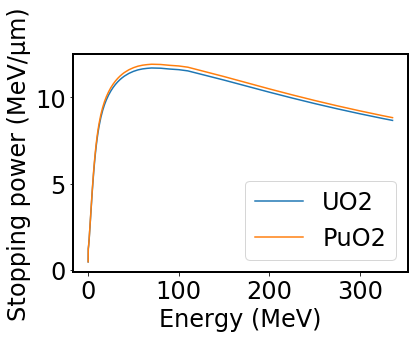

In [15]:
plt.figure()
plt.plot(UO2.energy_raw, UO2.dEdX_raw, label='UO2')
plt.plot(PuO2.energy_raw, PuO2.dEdX_raw, label='PuO2')
plt.xlabel('Energy (MeV)')
plt.ylabel('Stopping power (MeV/µm)')
plt.legend()
plt.show()

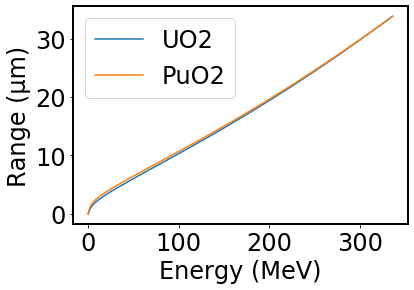

In [16]:
plt.figure()
plt.plot(UO2.energy_raw, UO2.GetRange(UO2.energy_raw), label='UO2')
plt.plot(PuO2.energy_raw, PuO2.GetRange(PuO2.energy_raw, from_sr=True), label='PuO2')
plt.xlabel('Energy (MeV)')
plt.ylabel('Range (µm)')
plt.legend()
plt.show()